# c04-boats

*Purpose*: Exploratory model analysis is a way to learn about a model and thus the scenario that it describes. However, computationally-expensive models are challenging to study with EMA, as every function evaluation costs us a lot of compute time. This challenge is about applying EMA ideas to learn about boat hull design, and about interfacing with a more computationally-complex simulation code.


In [ ]:
import grama as gr
import pandas as pd
import time
DF = gr.Intention()
%matplotlib inline

# Context

This challenge comes with an additional simulation code written in Python. The code is in the file `boat_utils.py`, which you can inspect if you're interested. For the purposes of this challenge, you only need to load the simulation tools, and read the basics detailed below.


In [ ]:
# Boat analysis code
import boat_utils as boat

## Basics of Boat Hull Design

In order to float safely, a boat has to displace enough water to support its mass, and rotate back to upright as it is rolled by waves and wind. This desired behavior is governed by a surprisingly complex interplay between geometric and mass distribution factors in the boat's design. The following graphic depicts the cross-section of a simple boat hull, rotated $30^{\circ}$ from its upright position.


![Boat diagram](images/c04-boat-diagram.png)


Gravity applies a downward force at the center of mass (G), while buoyancy applies an upward force at the center of buoyancy (B'). These two forces apply a torque that rolls the boat---hopefully back towards its upright position! Naval engineers analyze this behavior using the *statical stability curve*---this is what the provided boat simulation tools compute.

The following is a statical stability curve for an example boat hull.


Execution time: 2.808 sec


/Users/zach/opt/anaconda3/envs/uqbook/lib/python3.9/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


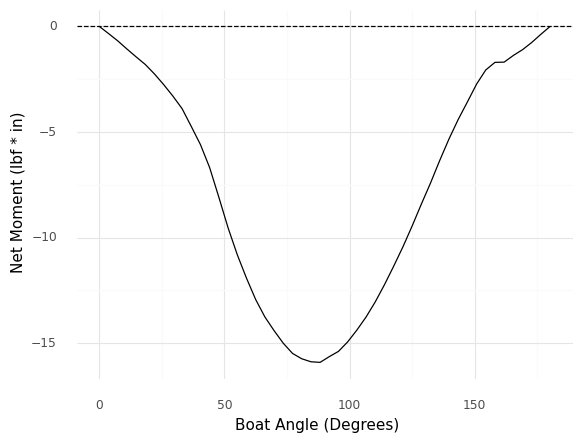

<ggplot: (8786632380209)>

In [2]:
# NOTE: No need to edit; this will analyze an example boat
t0 = time.time()
v_design = [2.5, 3.0, 2.0, 0.30, 0.35]
df_example = boat.fun_moment(v_design)
t1 = time.time()
print("Execution time: {0:4.3f} sec".format(t1 - t0))

(
    # Visualize the moment curve
    df_example
    >> gr.ggplot(gr.aes("angle * 180/3.14", "M_net"))
    + gr.geom_hline(yintercept=0, linetype="dashed")
    + gr.geom_line()
    
    + gr.scale_color_discrete(name=None)
    + gr.theme_minimal()
    + gr.labs(
        x="Boat Angle (Degrees)",
        y="Net Moment (lbf * in)",
    )
)

Some things worth noting about this example:

- The Boat Angle is the angle to which the boat hull is rotated (along its long axis).
- When the net moment is negative, a restoring torque acts to turn the boat back to upright.
- When the net moment is positive, an anti-restoring torque is applied.
<!-- - The point where the moment curve passes through the axis `M_net == 0` with positive slope is called the *angle of vanishing stability* (AVS). Rotating the boat beyond this point will cause it to settle upside-down. -->
- The boat analysis takes a non-trivial amount of time to run! Analyzing a large number of boat designs will take a fair amount of simulation time.


## Upright Stability

Note that upright stability is *not* guaranteed, even when comparing boats of identical geometry. Upright stability depends on a *restoring* moment acting when the boat is rotated away from upright.

> For a boat to be upright-stable, the slope of its moment curve must be **negative** at the angle $\theta = 0^{\circ}$.

The following boat has identical hull geometry as the previous case, but is lighter (smaller `d`) and has a higher center of mass (larger `f_com`).


Execution time: 2.786 sec


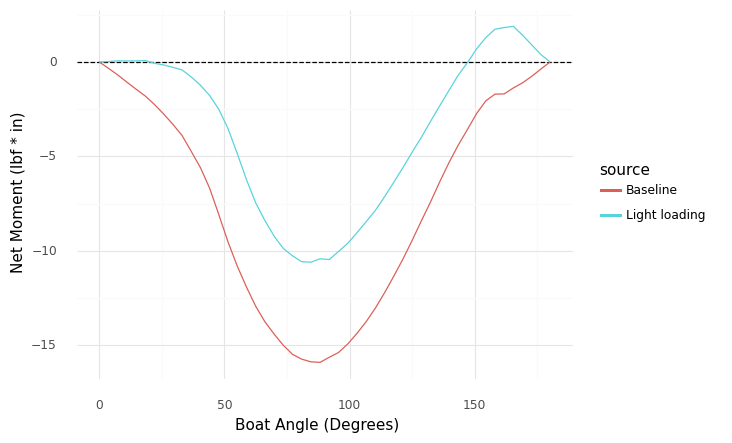

<ggplot: (8786632031687)>

In [3]:
# NOTE: No need to edit; this will analyze an example boat
t0 = time.time()
v_light = [2.5, 3.0, 2.0, 0.20, 0.40]
df_light = boat.fun_moment(v_light)
t1 = time.time()
print("Execution time: {0:4.3f} sec".format(t1 - t0))

(
    # Visualize the moment curve
    df_light
    >> gr.tf_mutate(source="Light loading")
    >> gr.tf_bind_rows(
        df_example
        >> gr.tf_mutate(source="Baseline")
    )
    >> gr.ggplot(gr.aes("angle * 180/3.14", "M_net", color="source"))
    + gr.geom_hline(yintercept=0, linetype="dashed")
    + gr.geom_line()
    
    + gr.scale_color_discrete(name=None)
    + gr.theme_minimal()
    + gr.labs(
        x="Boat Angle (Degrees)",
        y="Net Moment (lbf * in)",
    )
)

Note that the loading conditions of the boat have destabilized it at upright; the slope of the moment curve at $0^{\circ}$ is now positive.

This phenomenon is dangerous for vessels that must operate in both heavily-loaded and lightly-loaded conditions: Imagine a large transport ship in-harbor that has just unloaded cargo. The destabilizing phenomenon we see here would put the crew and dockworkers in considerable danger.


```{admonition} Developing insight through EMA
The traditional way to learn about boat stability is to carry out a variety of analytical derivations. In this challenge, you will use computational EMA tools to build some intuition about how design variables affect boat stability.
```

## Archival Data

For this challenge, you have available a set of pre-computed simulation results. The following code loads this archival dataset.


In [4]:
# NOTE: No need to edit; load the archival data
filename_archival = "./data/doe-wide.csv"
df_archival = pd.read_csv(filename_archival)
df_archival.head()

,d,n,f_com,H,W,M_max,mass,dMdtheta_avs,dMdtheta_0,M_min,BM,angle,int_M_stable,GM
0,0.414694,0.969522,0.384112,1.931260,1.390651,5.004726e-16,0.019592,NaN,-1.459991,-4.952630,0.108234,NaN,-8.019885,0.193949
1,0.242507,1.195436,0.656740,2.713299,3.580954,7.277457e+00,0.046730,NaN,9.916728,-5.402567,0.425216,NaN,3.675911,-0.557773
2,0.441223,0.936345,0.672138,1.446188,3.744617,6.550768e+00,0.040910,8.237037,-11.668754,-5.879390,1.073773,1.617128,-5.681558,0.768485
3,0.689483,0.882652,0.648739,1.210221,2.530339,1.149756e+00,0.034526,2.380926,-8.409095,-2.228434,0.764303,1.509121,-2.070254,0.652657
4,0.497305,0.780804,0.235978,2.502149,1.505777,7.886234e-16,0.029039,NaN,-8.644337,-14.019720,0.103794,NaN,-25.533024,0.796536


### Data Dictionary

There is *a lot* of information available in this dataset; the following is a summary of what's in the data:

| Column | I/O | Meaning |
|---|---|---|
| `d` | Input | Displacement ratio (-) |
| `n` | Input | Shape factor (-) |
| `f_com` | Input | Height of COM from boat bottom (-) |
| `H` | Input | Height of boat (in) |
| `W` | Input | Width of boat (in) |
|---|---|---|
| `M_max` | Output | Max righting moment (`lbf*in`) |
| `M_min` | Output | Min righting moment (`lbf*in`) |
| `mass` | Output | Boat mass (lb) |
| `dMdtheta_avs` | Output | Slope of moment curve at AVS (`lbf in/rad`) |
| `dMdtheta_0` | Output | Slope of moment curve at upright (`lbf*in/rad`) |
| `int_M_stable` | Output | Integral of moment curve, up to the AVS (`lbf*in*rad`) |
| `BM` | Output | Metacentric radius (in) |
| `GM` | Output | Metacentric height (in) |
| `angle` | Output | Angle of vanishing stability (rad) |


In [5]:
# NOTE: No need to edit; list out the variable names
var = ["d", "n", "f_com", "H", "W"]
out = [
    "M_max", 
    "M_min", 
    "mass", 
    "dMdtheta_avs", 
    "dMdtheta_0", 
    "BM", 
    "GM",
    "angle",
    "int_M_stable",
]

# Guided EDA of Archival Data

Before going to EMA, let's start with an EDA of the archival data. This will help us frame the model work to come later.


### __q1__ First look

Use simple EDA techniques to answer the questions under *observations* below.


In [6]:
# TASK: Perform simple EDA, answer the questions below
(
    df_archival
# solution-begin
    >> gr.tf_select(var)
    >> gr.tf_describe()
# solution-end
)

,d,n,f_com,H,W
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.500331,0.996067,0.558131,1.993312,2.495072
std,0.145578,0.289920,0.258698,0.575360,0.866986
min,0.193538,0.397186,0.021512,0.805669,0.743843
25%,0.371881,0.742082,0.347104,1.491662,1.735603
50%,0.493970,0.990548,0.559862,1.998756,2.497156
75%,0.624360,1.248795,0.784277,2.491131,3.269928
max,0.829827,1.623170,1.066143,3.247645,4.259180


*Observations*

<!-- task-begin -->
- How many observations (distinct boat hulls) are there in-total?
  - (Your response here)
- What are rough bounds for each of the input variables? (You'll use these in a later task....)
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How many observations (distinct boat hulls) are there in-total?
  - There are `1000` observations.
- What are rough bounds for each of the input variables?

| Var | Bounds |
|---|---|
| `d` | `[0.19, 0.83]` |
| `n` | `[0.39, 1.63]` |
| `f_com` | `[0.02, 1.07]` |
| `H` | `[0.74, 4.26]` |
| `W` | `[0.74, 4.26]` |

<!-- solution-end -->


### __q2__ How many designs are upright-stable?

Remember that upright-stable means the slope of the moment curve at an upright position is negative. Answer the questions under *observations* below.


In [7]:
(
    df_archival
# solution-begin
    >> gr.tf_count(DF.dMdtheta_0 < 0)
    >> gr.tf_mutate(
        f=DF.n / gr.sum(DF.n)
    )
# solution-end
)

,dMdtheta_0,n,f
0,False,330,0.33
1,True,670,0.67


*Observations*

<!-- task-begin -->
- How many boat designs in the dataset are upright-stable?
  - (Your response here)
- What *fraction* of boat designs in the dataset are upright-stable?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How many boat designs in the dataset are upright-stable?
  - There are `670` upright-stable boats.
- What *fraction* of boat designs in the dataset are upright-stable?
  - This is `67%` percent of the dataset.
<!-- solution-end -->


## Hypothesis: Width controls upright stability

To help frame the rest of this challenge, let's pose and assess a particular hypothesis:

> A wider boat will tend to have greater upright stability. Thus, we can make a boat stable by making it wider.

This seems intuitive, but is it true? Let's find out!


### __q3__ Correlation tile plot

Construct a correlation tile plot to study the input/output relationships. Answer the questions under *observations* below.


Calling plot_corrtile....


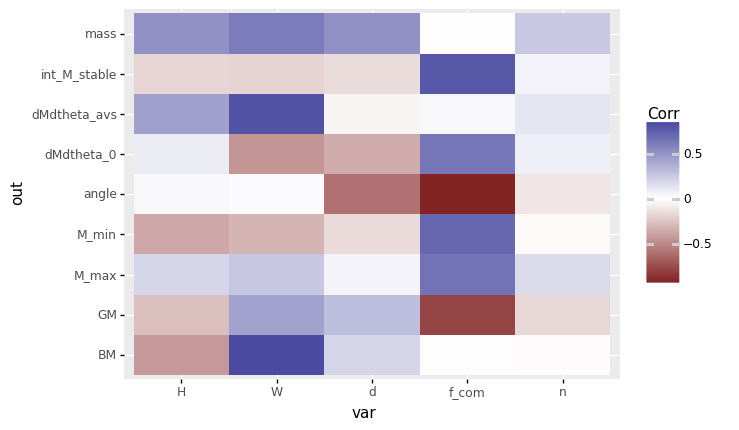

<ggplot: (8786632248501)>

In [8]:
(
    df_archival
# task-begin
    ## Compute the input/output correlation data here
# task-end
# solution-begin
    >> gr.tf_iocorr(var=var, out=out, nan_drop=True)
# solution-end
    ## NOTE: No need to edit; this will visualize your data
    >> gr.pt_auto()
)

*Observations*

<!-- task-begin -->
- Which inputs correlate strongly with the slope of the moment curve at upright (`dMdtheta_0`)?
  - (Your response here)
- For each of the inputs you identified above, what is the sign of the correlation? (Positive or negative?) For each input, what kind of change (increase or decrease) is required to increase upright stability?
  - (Your response here)
- How do these results relate to the hypothesis above?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Which inputs correlate strongly with the slope of the moment curve at upright (`dMdtheta_0`)?
  - The inputs `W, d, f_com` correlate strongly with `dMdtheta_0`.
- For each of the inputs you identified above, what is the sign of the correlation? (Positive or negative?) For each input, what kind of change (increase or decrease) is required to increase upright stability?
  - `W` correlates negatively with `dMdtheta_0`; increasing `W` increases stability.
  - `d` correlates negatively with `dMdtheta_0`; increasing `d` increases stability.
  - `f_com` correlates negatively with `dMdtheta_0`; decreasing `f_com` increases stability.
- How do these results relate to the hypothesis above?
  - These results are broadly in agreement with the hypothesis; a wider boat is indeed with a more stable boat. It remains to be seen if widening a given boat is sufficient to guarantee its stability.
<!-- solution-end -->


### __q4__ Detailed scatterplots

Make scatterplots to study relationship between `dMdtheta_0` and the relevant inputs you identified above. Add a smooth trend to each scatterplot with `gr.geom_smooth()`. Answer the questions under *observations* below.

*Hint*: While it is possible to construct all three plots in a single code cell, you should feel free to create additional cells as-necessary.


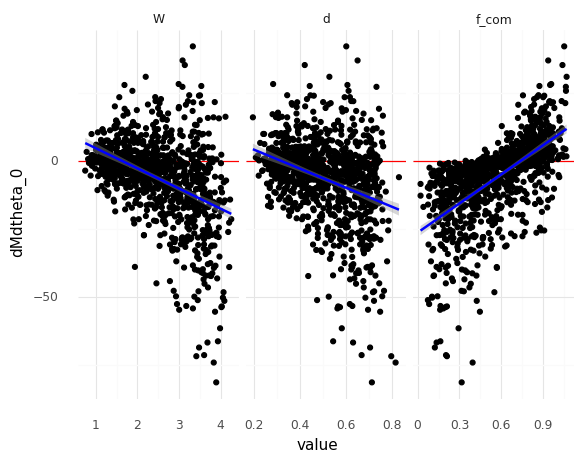

<ggplot: (8786631749111)>

In [9]:
# TODO: Create scatterplots
# solution-begin
(
    df_archival
    >> gr.tf_select(
        "dMdtheta_0",
        "W",
        "d",
        "f_com"
    )
    >> gr.tf_pivot_longer(
        columns=["W", "d", "f_com"],
        names_to="var",
        values_to="value",
    )
    
    >> gr.ggplot(gr.aes("value", "dMdtheta_0"))
    + gr.geom_hline(yintercept=0, color="red")
    + gr.geom_point()
    + gr.geom_smooth(color="blue")
    + gr.facet_grid("~var", scales="free_x")
    + gr.theme_minimal()
)
# solution-end

*Observations*

<!-- task-begin -->
- Is the observed variability real or erroneous?
  - (Your response here)
- Describe the effects of each input on the output `dMdtheta_0`.
  - (Your response here)
- Do any of the inputs have a more *predictable* effect on `dMdtheta_0`?
  - (Your response here)
- How do these results relate to the hypothesis above?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Is the observed variability real or erroneous?
  - Real
- Describe the effects of each input on the output `dMdtheta_0`.
  - `W` and `d` have a negative effect, while `f_com` has a positive effect.
- Do any of the inputs have a more *predictable* effect on `dMdtheta_0`?
  - `f_com` has a fairly predictive effect on upright stability; note that at `f_com <= 0.3`, we see that all of the archival cases are upright stable (regardless of the other design variables). For larger values `f_com` alone is not sufficient to control upright stability.
  - On their own, neither `W` nor `d` is highly predictive of `dMdtheta_0`.
- How do these results relate to the hypothesis above?
  - While widening a boat does indeed *tend* to increase its upright stability, widening a boat alone is not enough to *guarantee* its stability. We actually see that `f_com` has a more predictable effect on stability than `W`.
<!-- solution-end -->


Having carried out an EDA of the archival data, we can move on to studying behavior using the model. However, first we need to *setup* the model.


# Model Setup

The primary tool we need from the boat simulation utilities is the performance function, called like so:

```python
v = [2.5, 3.0, 2.0, 0.30, 0.35]
df_res = boat.fun_performance(v)
```

We will use this function to compute performance metrics (such as `dMdtheta_0`) for various boat designs. However, before we do so, we should quantify how long it takes to run the performance function. Doing so will help us *plan* our EMA evaluations, so that we don't try to execute a study that will take too long.


### __q5__ Time the analysis

Evaluate the boat performance function *inside* the loop below in order to complete the timing study.

*Hint*: Remember that `v_design` was assigned above in an example chunk. You can use that as the argument to `fun_performance()`.


In [10]:
n_rep = 5

t0 = time.time()
for i in range(n_rep):
# task-begin
    # Evaluate the boat performance function here to
    # complete the timing study
# task-end
# solution-begin
    df_res = boat.fun_performance(v_design)
# solution-end
t1 = time.time()

t_exec = (t1 - t0) / n_rep

print("Average execution time: {0:} sec".format(t_exec))


Average execution time: 1.9369175910949707 sec


### __q6__ Define the input order

List the inputs to `boat.fun_performance()` in the correct order. You will use this to assemble the model below.

*Hint*: Remember to consult the documentation for `boat.fun_performance()` to see the order of its arguments.


In [11]:
## TODO:
# task-begin
var_performance = []
# task-end
# solution-begin
var_performance = ["H", "W", "n", "d", "f_com"]
# solution-end

## NOTE: No need to edit; this defines the output quantities
out_performance = [
    "mass",
    "GM",
    "angle",
    "dMdtheta_0",
    "dMdtheta_avs",
    "M_max",
    "M_min",
    "int_M_stable",
]

## NOTE: No need to edit; use this to check your work
assert \
    set(var_performance) == set(boat.var_correct), \
    "Inputs not correct"
assert \
    var_performance == boat.var_correct, \
    "Inputs are not in the correct order; check " + \
    "the documentation for boat.fun_performance()."

```{admonition} Why does order matter?
By default, Python functions interpret their inputs based on **order**. Grama takes care of variables based on **name**, but when working with a "regular" Python function, we have to be careful to give grama the correct order information. Imagine giving the value for boat height `H` as the shape factor `n`, or vice versa! If we are careful when defining a grama model, we can prevent these order issues later.
```

### __q7__ Assemble the model

Complete the code below to assemple the boat performance model. Use the values assigned above as arguments to `gr.cp_function()`, including the variable names, output names, and runtime estimate. Make sure to add bounds for the inputs that "enclose" the observed archival data.

```{admonition} Why not `gr.cp_vec_function()`?
Here we use `gr.cp_function()` rather than `gr.cp_vec_function()`. This is because the boat performance function is not *vectorized*; it cannot take a DataFrame as its input. Generally we use `gr.cp_function()` with more "expensive" to evaluate functions.
```

In [12]:
## TODO: Complete the code below
md_performance = (
    gr.Model("Boat performance")
    >> gr.cp_function(
        fun=boat.fun_performance,
# task-begin
        # Add input and output names;
        # runtime estimate
# task-end
# solution-begin
        var=var_performance,
        out=out_performance,
        name="Performance metrics",
        runtime=t_exec,
# solution-end
    )
    >> gr.cp_bounds(
# task-begin
        # Add input bounds
# task-end
# solution-begin
        d=[0.19, 0.83],
        n=[0.39, 1.63],
        f_com=[0.02, 1.07],
        H=[0.74, 4.26],
        W=[0.74, 4.26],
# solution-end
    )
)

## NOTE: No need to edit; use this to check your work
assert \
    md_performance.functions[0].runtime > 0, \
    "Model has no runtime estimate"
for v in var_performance:
    assert \
        md_performance.domain.bounds[v][0] < df_archival[v].min(), \
        "Archival data for {} exceeds model lower bound".format(v)
    assert \
        df_archival[v].max() < md_performance.domain.bounds[v][1], \
        "Archival data for {} exceeds model upper bound".format(v)

md_performance

model: Boat performance

  inputs:
    var_det:
      H: [0.74, 4.26]
      d: [0.19, 0.83]
      n: [0.39, 1.63]
      f_com: [0.02, 1.07]
      W: [0.74, 4.26]

    var_rand:

    copula:
      None

  functions:
      Performance metrics: ['H', 'W', 'n', 'd', 'f_com'] -> ['mass', 'GM', 'angle', 'dMdtheta_0', 'dMdtheta_avs', 'M_max', 'M_min', 'int_M_stable']

# EMA with Expensive Models

We've seen trends in the detailed scatterplots, but we should confirm them with the real model. A sinew plot will help us confirm what we saw above and better-assess the width hypothesis.

*However*, note that the analysis code we're using has a nontrivial runtime; we should be careful about how many evaluations we request or we could be waiting a *long* time for the simulation to run. The following task will guide you through balancing runtime with exploring the model's behavior.


### __q8__ Plan a study

Tune the arguments to achieve a "reasonable" runtime. You will need to decide for yourself what a reasonable runtime is (though it will at a minimum be ~3 minutes.) Answer the questions under *observations* below.

*Hint 1*: Remember to use the documentation for a function to see which arguments to `gr.ev_sinews()` you can tune.

*Hint 2*: Running at least three sweeps will help with the task that comes after this one.


In [16]:
## TODO: Tune the arguments for gr.ev_sinews()
# to get a "reasonable" runtime
(
    md_performance
    >> gr.ev_sinews(
        df_det="swp", # Sweep all deterministic inputs
        skip=True,    # This prevents execution!
# solution-begin
        n_density=8,
        n_sweeps=3,
# solution-end
    )
)

Estimated runtime for design with model (Boat performance):
  2.32e+02 sec


,n,W,H,d,f_com,sweep_var,sweep_ind
0,0.554974,2.372360,0.740000,0.785748,0.444069,H,0
1,0.554974,2.372360,1.242857,0.785748,0.444069,H,0
2,0.554974,2.372360,1.745714,0.785748,0.444069,H,0
3,0.554974,2.372360,2.248571,0.785748,0.444069,H,0
4,0.554974,2.372360,2.751429,0.785748,0.444069,H,0
...,...,...,...,...,...,...,...
115,1.057619,2.248571,1.170901,0.221409,1.000549,W,2
116,1.057619,2.751429,1.170901,0.221409,1.000549,W,2
117,1.057619,3.254286,1.170901,0.221409,1.000549,W,2
118,1.057619,3.757143,1.170901,0.221409,1.000549,W,2


*Observations*

<!-- task-begin -->
- What is the predicted runtime?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- What is the predicted runtime?
  - For me: `230` seconds, or `3.8` minutes
  - This will vary quite a bit based on simulation parameters and machine hardware.
<!-- solution-end -->


### __q9__ Run the study

Now, use the settings you determined above and run the study! Answer the questions under *observations* below.

*Note*: It's a good idea to set this to run, go make yourself a coffee, then come back!


In [17]:
t0 = time.time()
df_sinews = (
    md_performance
    >> gr.ev_sinews(
        df_det="swp", # Sweep all deterministic inputs
# task-begin
        ## Use the same settings you determined above
# task-end
# solution-begin
        n_density=8,
        n_sweeps=3,
# solution-end
    )
)
t1 = time.time()
print("Execution time: {} sec".format(t1 - t0))


Execution time: 268.5545961856842 sec


Once the evaluation is complete, visualize the results with the following code.


Calling plot_sinew_outputs....


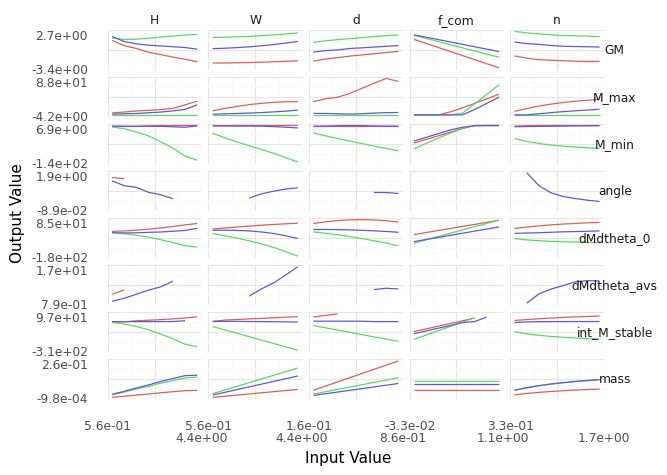

<ggplot: (8786622537415)>

In [18]:
# NOTE: No need to edit; use this to visualize the results
(
    df_sinews
    >> gr.pt_auto()
)

*Observations*

<!-- task-begin -->
- How close to the predicted runtime is the actual runtime?
  - (Your response here)
- Consider the variables you identified above that affect `dMdtheta_0`. Do they have a *consistent* effect on upright stability, or does their effect depend on the value of other inputs?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How close to the predicted runtime is the actual runtime?
  - (Your response here)
- Consider the variables you identified above that affect `dMdtheta_0`. Do they have a *consistent* effect on upright stability, or does their effect depend on the value of other inputs? Are their effects *always* positive/negative, or can their direction change?
  - The effects of `W`, `d` and `f_com` are conditional; rather than parallel curves, I see curves that intersect and have different strength associated with the various sweeps. 
  - Most surprisingly (and not all students will see this): The "sign" of effect for `W` and `d` is not always consistent; for some cases, increasing `W`/`d` actually *decreases* the upright stability.
  - From these results it appears that `f_com` always has a consistent effect: Its slope is generally positive, though it does vary in magnitude. 
<!-- solution-end -->
